In [88]:
from dataset.dataset import NERDataset
from torch.utils.data import DataLoader
import numpy as np
from typing import Sequence, List, Tuple

train_data = NERDataset(tokenizer="glove", cased=True, mode='train')
val_data = NERDataset(tokenizer="glove", cased=False, mode='valid')

## 1. Main train loop


In [13]:
import torch.optim as optim
import torch.nn as nn
import torch
from models.transformerTagger import TransformerTagger
from models.lstmTagger import LSTMTagger
from models.transformerTagger import PositionalEncoder
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import datetime as dt
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import F1Score, Accuracy, Precision, Recall
import utils
import time
from collections import Counter
import itertools
import pandas as pd
import torch


TODAY = dt.datetime.today().strftime("%Y-%m-%d")

BATCH_SIZE = 256
BASE_LR = 1e-3
MAX_EPOCHS = 20
RUN_NO = 1
LOG_DIR = "./log/traininglog"
MINIBATCH_SIZE = 16
WRITER = SummaryWriter(log_dir=f"{LOG_DIR}/{TODAY}_runno_{RUN_NO}")
SAVE_EVERY = 5
SAVE_DIR = f"./checkpoints/{TODAY}_runo{RUN_NO}.pt"
num_decoder_layers = 8
num_encoder_layers = 8
d_model = 256
nhead = 32
num_dense_layers = 7
model_type = "lstm"
layer_norm_eps = .001
lstm_input_size = 256


class_weights = pd.Series(Counter(itertools.chain(*[[i.item() for i in t] 
    for t in train_data.data.target_idx])))
# class_weights /= class_weights.sum()
class_weights = 1 / class_weights
class_weights.loc[0] = 0
class_weights = torch.tensor(class_weights.sort_index().values)


f1 = F1Score(num_classes=10, threshold=0.2)
accu = Accuracy(threshold=0.2, num_classes=10)
precision = Precision(num_classes=10)
recall = Recall(num_classes=10, threshold=0.2)

feature_padding_value = train_data._tokenidx.get(train_data.pad_token)
tag_padding_value = train_data._targetidx.get(train_data.pad_token)

def collate_fn(data: Sequence[Tuple], 
    n_classes: int=train_data.ntargets,
    feature_padding_value=feature_padding_value,
    tag_padding_value=tag_padding_value,):
    """:return: features, target_prob, target, mask (save dims as target_prob)"""
    features, target_prob, targets, idx = zip(*data)
    features = pad_sequence(features, batch_first=True, padding_value=feature_padding_value)
    targets = pad_sequence(targets, batch_first=True, padding_value=tag_padding_value)
    max_len = targets.shape[1]
    batch_size=targets.shape[0]
    target_prob, target_mask = utils.pad_target_prob(target_prob, n_classes - 1, max_len, n_classes, batch_size)

    return (idx, 
        features.long(), target_prob.to(torch.float64), 
        targets.long(), target_mask.bool()
        )

train_dataloader = DataLoader(train_data, 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    collate_fn=collate_fn
        )

val_dataloader = DataLoader(val_data, 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    collate_fn=collate_fn
        )

if model_type.lower() in ["transformer", "tranformertagger"]:
    model = TransformerTagger(d_model=d_model, 
            n_tags=train_data.ntargets, 
            vocab_size=train_data.vocab_size + 1,
            nhead=nhead, 
            batch_first=True, 
            num_decoder_layers=num_decoder_layers,
            num_encoder_layers=num_encoder_layers,
            num_dense_layers=num_dense_layers,
            pad_token_idx=train_data._tokenidx.get(train_data.pad_token))

elif model_type.lower() in ["lstm", "lstmtagger"]:
    model = LSTMTagger(d_model=d_model,
        n_tags=train_data.ntargets, 
        num_decoder_layers=num_decoder_layers,
        num_encoder_layers=num_decoder_layers,
        vocab_size=train_data.vocab_size + 1,
        layer_norm_eps=layer_norm_eps,
        activation=torch.tanh,
        input_size=lstm_input_size,
        batch_first=True, 
        num_dense_layers=num_dense_layers,
        pad_token_idx=train_data._tokenidx.get(train_data.pad_token)
    )




optimizer = optim.Adam(params=model.parameters(), 
    lr=BASE_LR,
    eps=1e-5,
    betas=(0.9, 0.99))

criterion = nn.NLLLoss(ignore_index=0, reduction='mean')
start = time.time()

global_step = 1
try:
    for epoch in range(MAX_EPOCHS):
        print(f"running epoch {epoch}")
        running_loss = 0.
        model.train()
        counter = 0
        train_precision, train_recall, train_f1, train_accu = 0., 0., 0., 0.
        for i, data in enumerate(train_dataloader):
            print(f"iter_no{i}")
            optimizer.zero_grad()
            idx, src, tag_prob, tags, mask = data
            if model_type.lower() in ["lstm", "lstmtagger"]:
                pred = model(src, mask)
            elif model_type.lower() in ["transformer", "transformertagger"]:
                pred = model(src, src, mask)
            else: raise ValueError("model type not recognized")
            loss = criterion(pred[~mask], tags[~mask])
            for j, (prd, truth, mk) in enumerate(zip(pred, tags, mask)):
                # loss += criterion(prd[~mk], truth.masked_select(~mk).long())
                train_precision += precision(prd[~mk], truth.masked_select(~mk).long()).item()
                train_recall += recall(prd[~mk], truth.masked_select(~mk).long()).item()
                train_f1 += f1(prd[~mk], truth.masked_select(~mk).long()).item()
                train_accu += accu(prd[~mk], truth.masked_select(~mk).long()).item()
                counter += 1
            loss.backward()
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 
                max_norm=1e2, 
                norm_type=2.0, 
                error_if_nonfinite=False) # gradient clipping
            running_loss += loss.item()
            WRITER.add_scalar("train/loss", loss.item(), 
                    walltime=time.time()-start,
                    global_step=global_step)
            break
        break
except Exception as exp:
    print(exp)

## 1.1 Check model size

In [14]:
import utils
utils.get_num_params(model) / 1e6

31.143434

## 2. Check dataset properties

/var/folders/nv/5lrdv19x6516010dtwg9ny440000gn/T/ipykernel_68106/3348950956.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  class_weights.sort_index(0).plot(kind="bar", figsize=(10, 5), title="tag distribution in the training data")


<AxesSubplot:title={'center':'tag distribution in the training data'}>

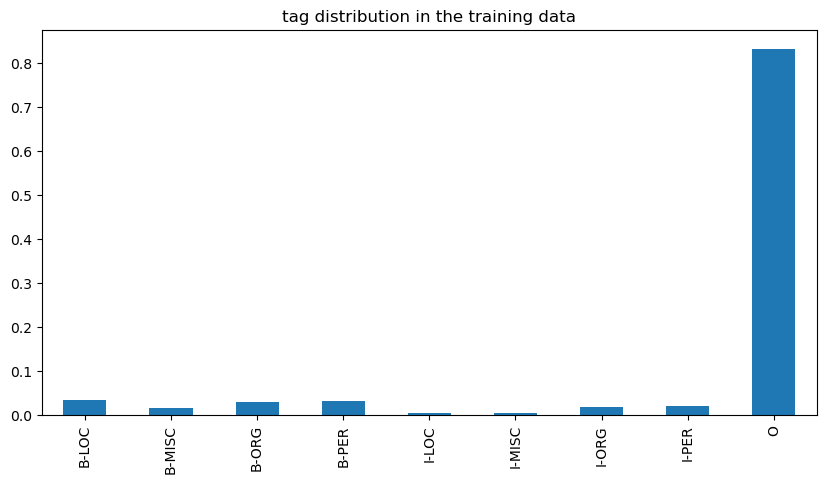

In [ ]:
class_weights.rename(train_data._target_lookup, inplace=True)
class_weights.sort_index(0).plot(kind="bar", figsize=(10, 5), title="tag distribution in the training data")

In [25]:
print([f"""{x}: {eval(f"len({x}_data.data)")}""" for x in ["train", "val", "test"]])

[' train: 14986', ' val: 3465', ' test: 3683']


In [38]:
total_num_tokens = train_data.data.text_idx.apply(lambda x: len(x)).sum()

In [41]:
import itertools
from collections import Counter
top_tokens = Counter(itertools.chain(
    *train_data.data.text_idx.apply(lambda x: [i.item() for i in x])
    )).most_common(50)

In [44]:
top_tokens = pd.DataFrame(top_tokens, columns=["token_id", "token_count"])
top_tokens.token_count = top_tokens.token_count / total_num_tokens
top_tokens.token_id = top_tokens.token_id.apply(train_data.get_token_from_idx)

<AxesSubplot:title={'center':'train data sentence length distribution'}, ylabel='Density'>

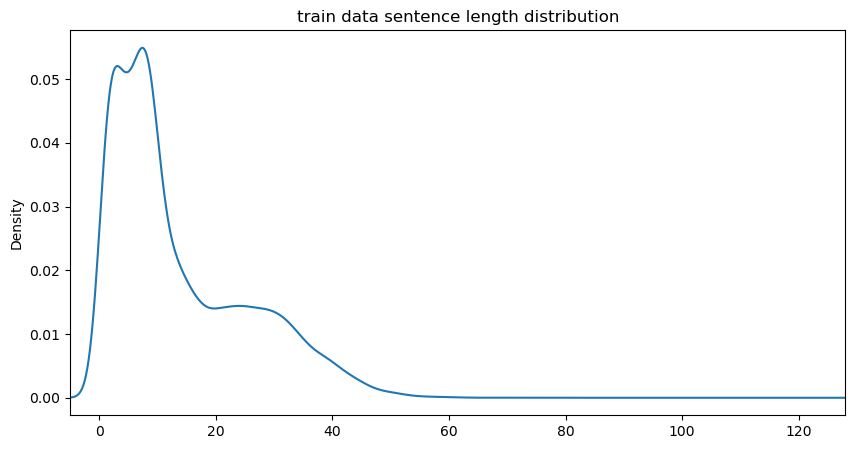

In [64]:
train_data.data.text_idx.apply(lambda x: len(x)).plot(kind="kde", xlim=(-5, 128), 
    figsize=(10, 5),
    title="train data sentence length distribution")

In [6]:
import json
from pathlib import Path

with Path("./embeddings/spacy_train_cased_2022-11-13.json").open("w") as f: 
    json.dump(train_data._tokenidx, f)

In [8]:
with Path("./embeddings/nertag_idx.json").open("w") as f: 
    json.dump(train_data._targetidx, f)

In [31]:
from torchmetrics import F1Score, Accuracy, Precision, Recall
f1 = F1Score(num_classes=10, threshold=0.5)
accu = Accuracy(threshold=0.5, num_classes=10)
precision = Precision(num_classes=10)
recall = Recall(num_classes=10, threshold=0.5)
f1(pred_prob[0], tag_prob[0].long())

tensor(0.)